In [16]:
import netket
from flax.core.scope import CollectionFilter
from netket.utils.types import PyTree
from netket.operator import Squared
from functools import partial, lru_cache
from typing import Callable, Optional

import jax
from jax import numpy as jnp
from flax.core.scope import CollectionFilter, DenyList  # noqa: F401

import netket as nk
from netket import jax as nkjax
from netket.operator import DiscreteOperator, Squared
from netket.stats import Stats
from netket.utils.types import PyTree
from netket.utils.dispatch import dispatch

# from nektet.vqs import _ex
from netket.vqs import expect_and_grad, expect_and_forces
from netket.vqs.mc.common import force_to_grad, get_local_kernel, get_local_kernel_arguments
from netket.stats import Stats
import time
import json
import matplotlib.pyplot as plt
import numpy as np
from netket.operator.spin import sigmax, sigmay,sigmaz
from netket.stats import Stats, statistics

from functools import partial
from typing import Callable, Optional

import jax
from jax import numpy as jnp
from flax.core.scope import CollectionFilter, DenyList  # noqa: F401

from netket import jax as nkjax
from netket import config
from netket.stats import Stats
from netket.utils import mpi, dispatch
from netket.utils.types import PyTree

from netket.operator import (
    AbstractOperator,
    Squared,
)

from netket.vqs import expect_and_grad, expect_and_forces
from netket.vqs import MCState

In [41]:
# Define the Hilbert space based on this graph
# We impose to have a fixed total magnetization of zero
# Define a 1d chain
L = 8
dis = 1
g = nk.graph.Hypercube(length=L, n_dim=1, pbc=True)
hi = nk.hilbert.Spin(s=0.5, total_sz=0, N=g.n_nodes)
# calling the Heisenberg Hamiltonian
ha = nk.operator.Heisenberg(hilbert=hi, graph=g)
# ha = nk.operator.Heisenberg(hilbert=hi, graph=g)
b=dis
a=-dis
Gamma = (b-a) * np.random.random_sample(L) + a

################################################################################
################################################################################
################################################################################
#이렇게 정의하는게 더 빨랑
ha = sum([ sigmax(hi,i)*sigmax(hi,(i+1)%L)
         + sigmay(hi,i)*sigmay(hi,(i+1)%L)
         + sigmaz(hi,i)*sigmaz(hi,(i+1)%L)
           for i in range(L)])
################################################################################
################################################################################
################################################################################
ha = ha + sum([Gamma[i]*sigmaz(hi,i) for i in range(L)])

In [42]:
Et = -np.random.uniform(low=0, high=L, size=None)
Et

-1.1055777544125194

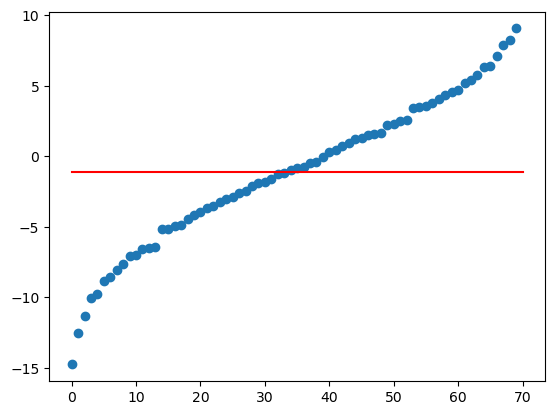

In [43]:
E, vec = np.linalg.eigh(ha.to_dense())
plt.scatter(range(len(E)),E)
plt.plot([0,len(E)],[Et,Et],'r')

In [44]:
E

array([-14.76150897, -12.55337463, -11.32908176, -10.0820216 ,
        -9.74270552,  -8.85064349,  -8.56599845,  -8.09626721,
        -7.61477744,  -7.07364859,  -7.02547754,  -6.56361969,
        -6.52873865,  -6.41154756,  -5.15157384,  -5.14383633,
        -4.91367722,  -4.85324006,  -4.43431574,  -4.16927184,
        -3.96663438,  -3.66581485,  -3.49356305,  -3.25129644,
        -3.0069579 ,  -2.89553015,  -2.61311987,  -2.45518612,
        -2.07535219,  -1.89916182,  -1.8098791 ,  -1.63583476,
        -1.26846837,  -1.2022427 ,  -0.96788534,  -0.85707407,
        -0.75981447,  -0.50881038,  -0.38885172,  -0.03554715,
         0.31206789,   0.41722667,   0.71186764,   0.96579009,
         1.24289522,   1.31443505,   1.47852567,   1.57716508,
         1.67791996,   2.22390158,   2.31033879,   2.47987539,
         2.54283711,   3.44008679,   3.51119538,   3.59710314,
         3.75698645,   4.07513161,   4.37046548,   4.58477297,
         4.69600267,   5.19540546,   5.3743281 ,   5.75

In [45]:
ha_Et_squ = (ha-Et)@(ha-Et)
ha_Et = ha-Et

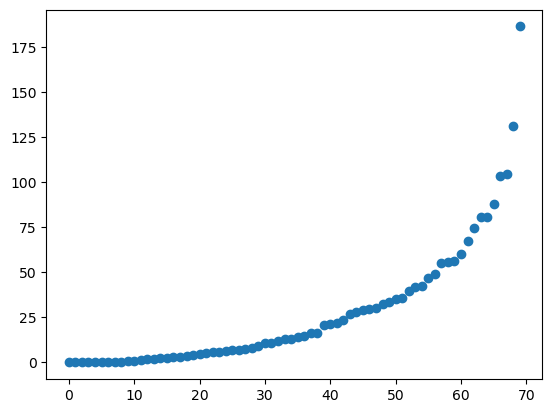

In [46]:
E, vec = np.linalg.eigh(ha_Et_squ.to_dense())
plt.scatter(range(len(E)),E)

In [47]:
def to_array(model, parameters):
    # begin by generating all configurations in the hilbert space.
    # all_States returns a batch of configurations that is (hi.n_states, N) large.
    all_configurations = hi.all_states()

    # now evaluate the model, and convert to a normalised wavefunction.
    logpsi = model.apply(parameters, all_configurations)
    psi = jnp.exp(logpsi)
    psi = psi / jnp.linalg.norm(psi)
    return psi

### 3.3 Energy
Now, using that function, let's build another one that computes the energy of the mean field state for the given parameters! 
To do that, you can for example convert the hamiltonian to a sparse format and compute the energy

In [48]:
def compute_energy(model, parameters, hamiltonian_sparse):
    psi = to_array(model, parameters)
    return psi.conj().T@(hamiltonian_sparse@psi)

In [49]:
def compute_variance(model, parameters, hamiltonian_sparse):
    psi = to_array(model, parameters)
    return psi.conj().T@(hamiltonian_sparse@hamiltonian_sparse@psi) - (psi.conj().T@(hamiltonian_sparse@psi))**2

In [50]:
# and like before, we can jit-compile it!
compute_energy_jit = jax.jit(compute_energy, static_argnames="model")

# and we precompute the sparse-hamiltonian to avoid the overhead of re-computing them all the time


hamiltonian_jax = ha.to_pauli_strings().to_jax_operator()
hamiltonian_sparse = ha.to_sparse()
hamiltonian_jax_sparse = hamiltonian_jax.to_sparse()

hamiltonian_Et_jax = ha_Et.to_pauli_strings().to_jax_operator()
hamiltonian_Et_sparse = ha_Et.to_sparse()
hamiltonian_Et_jax_sparse = hamiltonian_Et_jax.to_sparse()

hamiltonian_Et_squ_jax = ha_Et_squ.to_pauli_strings().to_jax_operator()
hamiltonian_Et_squ_sparse = ha_Et_squ.to_sparse()
hamiltonian_Et_squ_jax_sparse = hamiltonian_Et_squ_jax.to_sparse()

model = nk.models.RBM(alpha=2, param_dtype=complex)
key = jax.random.key(0)

parameters = model.init(key, np.random.rand(hi.size))

## 4. Monte Carlo complications 

Until now we did everything by summing over the whole hilbert space, but for larger problems that won't be possible. So let's look into MC sampling.

In [51]:
def compute_local_energies(model, parameters, hamiltonian_jax, sigma):
    eta, H_sigmaeta = hamiltonian_jax.get_conn_padded(sigma)
    
    logpsi_sigma = model.apply(parameters, sigma)
    logpsi_eta = model.apply(parameters, eta)
    logpsi_sigma = jnp.expand_dims(logpsi_sigma, -1) 
    
    res = jnp.sum(H_sigmaeta * jnp.exp(logpsi_eta - logpsi_sigma), axis=-1)
    
    return res

# def compute_second_local_energies(model, parameters1, parameters2, hamiltonian_jax, sigma):
#     eta, H_sigmaeta = hamiltonian_jax.get_conn_padded(sigma)
    
#     logpsi_sigma = model.apply(parameters1, sigma)
#     logpsi_eta = model.apply(parameters2, eta)
#     logpsi_sigma = jnp.expand_dims(logpsi_sigma, -1) 
    
#     res = jnp.sum(H_sigmaeta * jnp.exp(logpsi_eta - logpsi_sigma), axis=-1)
    
#     return res

### 4.3 Sampling the energy

So now write a function that computes the energy and estimates its error. I remind you that the error is given by 

$$
    \epsilon_E = \sqrt{\frac{\mathbb{V}\text{ar}(E_\text{loc})}{N_\text{samples}}}
$$

In [52]:
@partial(jax.jit, static_argnames='model')
def estimate_energy(model, parameters, hamiltonian_jax, sigma):
    E_loc = compute_local_energies(model, parameters, hamiltonian_jax, sigma)
    
    E_average = jnp.mean(E_loc)
    E_variance = jnp.var(E_loc)
    E_error = jnp.sqrt(E_variance / E_loc.size)
    
    # we return a netket Stats object that wraps all statistical information related to this mean value.
    return nk.stats.Stats(mean=E_average, error_of_mean=E_error, variance=E_variance)


### 4.4 Sampling the gradient of the energy 

We have seen during the class that the gradient of the energy can be estimated according to the formula

$$
    \nabla_k E = \mathbb{E}_{\sigma\sim|\psi(\sigma)|^2} \left[ (\nabla_k \log\psi(\sigma))^\star \left( E_\text{loc}(\sigma) - \langle E \rangle\right)\right] \approx \frac{1}{N_s}\sum_i^{N_s} (\nabla_k \log\psi(\sigma_i))^\star \left( E_\text{loc}(\sigma_i) - \langle E \rangle\right)
$$

Where $\langle E \rangle$ can be estimated as $\langle E \rangle \approx \frac{1}{N_s}\sum_i E_\text{loc}(\sigma_i)$

Now, for a second, think of $\nabla_k \log\psi(\sigma_i)$ as the _JACOBIAN_ of the function $\log\psi_\sigma : \mathbb{R}^{N_\text{pars}} \rightarrow \mathbb{R}^{N_\text{samples}}$, and think for a moment of $E_\text{loc}(\sigma_i)$ as a vector of size $\mathbb{R}^{N_\text{samples}}$

Now implement a function that computes the jacobian-vector product in order to estimate the gradient of the energy. You can either do this vector-Jacobian-transpose product manually by using `jax.jacrev` and `jax.tree.map`, but you can also have a look at `jax.vjp` which does it automatically for you.

In [53]:
def add(x,y):
    return x+y

In [54]:
@partial(jax.jit, static_argnames='model')
def estimate_energy_and_gradient(model, parameters, sigma):
    # reshape the samples to a vector of samples with no extra batch dimensions
    sigma = sigma.reshape(-1, sigma.shape[-1])
    
    E_loc_ha_Et_squ = compute_local_energies(model, parameters, hamiltonian_Et_squ_jax, sigma)
    E_loc_ha_Et = compute_local_energies(model, parameters, hamiltonian_Et_jax, sigma)
    
    # compute the energy as well
    E_average = jnp.mean(E_loc_ha_Et_squ)
    E_average_ha_Et = jnp.mean(E_loc_ha_Et)


    
    E_variance = jnp.var(E_loc_ha_Et_squ)
    E_error = jnp.sqrt(E_variance/E_loc_ha_Et_squ.size)
    E = nk.stats.Stats(mean=E_average, error_of_mean=E_loc_ha_Et_squ, variance=E_variance)

    # comptue the gradient ...
    # first define the function to be differentiated
    logpsi_sigma_fun = lambda pars : model.apply(pars, sigma)

    # use jacrev with jax.tree.map, or even better, jax.vjp
    _, vjpfun = jax.vjp(logpsi_sigma_fun, parameters)
    E_grad1 = vjpfun((E_loc_ha_Et_squ - E_average)/E_loc_ha_Et_squ.size)
    # E_grad2 = vjpfun(-2*(E_loc_ha_Et - 2*E_average_ha_Et)/E_loc_ha_Et_squ.size)

    # E_grad = jax.tree.map(add, E_grad1, E_grad2)
    E_grad = E_grad1

    return E, E_grad[0]

### 4.5: Let's get down to business

Now let's wrap everything up and let's use this code to compute the ground state with an SGD optimisation using the mean field and jastrow ansatz

In [55]:
from tqdm import tqdm
import optax

# settings 
# model = nk.models.RBM(alpha=2, param_dtype=complex)
model = nk.models.RBM(alpha=2, param_dtype=complex)
sampler = nk.sampler.MetropolisSampler(
                        hi,                            # the hilbert space to be sampled
                        nk.sampler.rules.ExchangeRule(graph=g),  # the transition rule
                        # nk.sampler.rules.LocalRule(),
                        n_chains = 16)
n_iters = 50000
chain_length = 512//sampler.n_chains

# initialise
parameters = model.init(jax.random.key(0), np.ones((hi.size, )))
sampler_state = sampler.init_state(model, parameters, seed=1)

optimizer = optax.adam(learning_rate=0.001)
optimizer_state = optimizer.init(parameters)


# logging: you can (if you want) use netket loggers to avoid writing a lot of boilerplate...
# they accumulate data you throw at them
logger = nk.logging.RuntimeLog()

for i in tqdm(range(n_iters)):
    # sample
    sampler_state = sampler.reset(model, parameters, state=sampler_state)
    samples, sampler_state = sampler.sample(model, parameters, state=sampler_state, chain_length=chain_length)
    
    # compute energy and gradient
    E, E_grad = estimate_energy_and_gradient(model, parameters, samples)
    updates, optimizer_state = optimizer.update(E_grad, optimizer_state, parameters)
    parameters = optax.apply_updates(parameters, updates)
    # logger(step=i, item={'Energy' : E})


100%|█████████████████████████████████████| 50000/50000 [26:48<00:00, 31.09it/s]


In [56]:
# to plot the data, access it!logger.data['Energy']['Mean'].real
# plt.plot(logger.data['Energy']['iters'], logger.data['Energy']['Mean'].real)
print('Energy : ',compute_energy(model, parameters, hamiltonian_jax).real)
print('Variance : ',compute_variance(model, parameters, hamiltonian_jax).real)

Energy :  -0.9208329474573962
Variance :  1.0419774424088453


### 5.2: Try better optimisers

There is a library, [optax](https://optax.readthedocs.io/en/latest/), that implements several optimisers. 
Try to use adam or other optimisers.
The way you use them is as follows:

In [ ]:
import optax

# define
optimizer = optax.adam(learning_rate=0.01)

# initialise
parameters = model.init(...)
optimizer_state = optimizer.init(parameters)

for i in range(n_iters):
    E, E_grad = estimate_energy_and_grad(..., parameters, ...)
    
    updates, optimizer_state = optimizer.update(E_grad, optimizer_state, parameters)
    parameters = optax.apply_updates(parameters, updates)


### 5.3: Sky's the limit

What you've seen so far gives you the tools to quickly get started in running VMC calculations, without having to worry about sampling (which is a bit tricky to implement) and operators (which are very tricky to implement).

You can use this as a starting point to implement stochastic reconfiguration, the dynamics, and much more!